In [57]:
import re
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from bert_logistic import read_texts_from_dir
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", category=UserWarning)

In [58]:
try:
    nltk.data.find("tokenizers/punkt")
except nltk.downloader.DownloadError:
    nltk.download("punkt")

# Tải mô hình spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Mô hình 'en_core_web_sm' chưa được tải. Vui lòng chạy:")
    print("python -m spacy download en_core_web_sm")
    nlp = None

### READ DATA

In [ ]:
train_path = "/home/thangquang09/CODE/CTAI_MachineLearning/data/fake-or-real-the-impostor-hunt/data/train"
test_path = "/home/thangquang09/CODE/CTAI_MachineLearning/data/fake-or-real-the-impostor-hunt/data/test"
gt_path = "/home/thangquang09/CODE/CTAI_MachineLearning/data/fake-or-real-the-impostor-hunt/data/train.csv"
print("Loading data...")
df_train = read_texts_from_dir(train_path)
df_test = read_texts_from_dir(test_path)
df_train_gt = pd.read_csv(gt_path)
y_train = df_train_gt["real_text_id"].values

df_train.rename(columns={"file_1": "text_0", "file_2": "text_1"}, inplace=True)
df_test.rename(columns={"file_1": "text_0", "file_2": "text_1"}, inplace=True)
df_train["label"] = df_train_gt["real_text_id"]

df_train["label"] = df_train["label"].map({1: 0, 2: 1})

Loading data...
Number of directories: 95
Number of directories: 1068


### FEATURE ENGINEERING

In [60]:
def create_numerical_features(dataframe):
    """
    Hàm này tạo ra các feature số từ các cột text_0 và text_1.
    """

    # Các hàm trợ giúp
    def get_word_count(text):
        return len(str(text).split())

    def get_sentence_count(text):
        return len(nltk.sent_tokenize(str(text)))

    def get_avg_word_length(text):
        words = str(text).split()
        if not words:
            return 0
        return sum(len(word) for word in words) / len(words)

    def get_ttr(text):
        tokens = [word.lower() for word in str(text).split()]
        if not tokens:
            return 0
        return len(set(tokens)) / len(tokens)

    def count_entities(text):
        if not nlp:
            return 0
        doc = nlp(str(text))
        return len(doc.ents)

    # Tính feature cho từng văn bản
    features = pd.DataFrame()
    for i in [0, 1]:
        features[f"word_count_{i}"] = dataframe[f"text_{i}"].apply(get_word_count)
        features[f"sentence_count_{i}"] = dataframe[f"text_{i}"].apply(
            get_sentence_count
        )
        features[f"avg_word_len_{i}"] = dataframe[f"text_{i}"].apply(
            get_avg_word_length
        )
        features[f"ttr_{i}"] = dataframe[f"text_{i}"].apply(get_ttr)
        if nlp:
            features[f"ner_count_{i}"] = dataframe[f"text_{i}"].apply(count_entities)

    # Tính feature so sánh (hiệu và tỉ lệ)
    feature_names = ["word_count", "sentence_count", "avg_word_len", "ttr"]
    if nlp:
        feature_names.append("ner_count")

    for name in feature_names:
        # Xử lý chia cho 0 bằng cách thêm một số rất nhỏ (epsilon)
        epsilon = 1e-6
        features[f"diff_{name}"] = features[f"{name}_1"] - features[f"{name}_0"]
        features[f"ratio_{name}"] = features[f"{name}_1"] / (
            features[f"{name}_0"] + epsilon
        )

    return features

In [61]:
numerical_features = create_numerical_features(df_train)
print(
    "\n✅ BƯỚC 2: Tạo các feature số thành công. Kích thước:", numerical_features.shape
)
print(numerical_features.head())


✅ BƯỚC 2: Tạo các feature số thành công. Kích thước: (95, 20)
    word_count_0  sentence_count_0  avg_word_len_0     ttr_0  ner_count_0  \
id                                                                          
0            304                 9        6.226974  0.802632           19   
1            454                 8        5.883260  0.698238           10   
2            159                 3        6.169811  0.823899            3   
3            263                 8        5.749049  0.726236           15   
4             34                 3        4.764706  0.882353            0   

    word_count_1  sentence_count_1  avg_word_len_1     ttr_1  ner_count_1  \
id                                                                          
0            296                10        5.820946  0.797297           11   
1            137                 4        5.839416  0.854015            5   
2            125                 3        5.416000  0.872000            7   
3           

In [62]:
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Sử dụng thiết bị: {device}")

e5_model = SentenceTransformer("intfloat/multilingual-e5-small", device=device)
sentences_0 = df_train["text_0"].tolist()
sentences_1 = df_train["text_1"].tolist()

embeddings_0 = e5_model.encode(sentences_0, show_progress_bar=True)
embeddings_1 = e5_model.encode(sentences_1, show_progress_bar=True)

embedding_dims = embeddings_0.shape[1]
e5_features_0 = pd.DataFrame(
    embeddings_0, columns=[f"e5_0_{i}" for i in range(embedding_dims)]
)
e5_features_1 = pd.DataFrame(
    embeddings_1, columns=[f"e5_1_{i}" for i in range(embedding_dims)]
)

print("\n✅ BƯỚC 3: Tạo embedding features thành công.")
print("Kích thước embedding cho text_0:", e5_features_0.shape)
print("Kích thước embedding cho text_1:", e5_features_1.shape)

Sử dụng thiết bị: cpu


Batches: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


✅ BƯỚC 3: Tạo embedding features thành công.
Kích thước embedding cho text_0: (95, 384)
Kích thước embedding cho text_1: (95, 384)


In [63]:
print("\nBắt đầu tạo TF-IDF features...")
vectorizer_params = {
    "ngram_range": (1, 3),
    "max_features": 2000,  # Giảm số lượng để kiểm soát nhiễu
    "min_df": 3,
    "stop_words": "english",
}

tfidf_vec_0 = TfidfVectorizer(**vectorizer_params)
tfidf_vec_1 = TfidfVectorizer(**vectorizer_params)

tfidf_0 = tfidf_vec_0.fit_transform(df_train["text_0"])
tfidf_1 = tfidf_vec_1.fit_transform(df_train["text_1"])
print("✅ BƯỚC 4: Tạo TF-IDF features thành công.")



Bắt đầu tạo TF-IDF features...
✅ BƯỚC 4: Tạo TF-IDF features thành công.


In [64]:
dense_features = pd.concat(
    [
        numerical_features.reset_index(drop=True),
        e5_features_0.reset_index(drop=True),
        e5_features_1.reset_index(drop=True),
    ],
    axis=1,
)

# Sử dụng hstack để kết hợp ma trận DENSE và các ma trận SPARSE (dạng thưa)
X = hstack(
    [dense_features.values, tfidf_0, tfidf_1]
).tocsr()  # .tocsr() để tối ưu hóa truy cập hàng

y = df_train["label"]

print("\n✅ BƯỚC 5: Kết hợp 'siêu' feature thành công.")
print("Kích thước ma trận cuối cùng X:", X.shape)


✅ BƯỚC 5: Kết hợp 'siêu' feature thành công.
Kích thước ma trận cuối cùng X: (95, 4788)


In [65]:
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
oof_preds = np.zeros(X.shape[0])
feature_importances = pd.DataFrame(index=numerical_features.columns)

print(f"\n✅ BƯỚC 6: Bắt đầu huấn luyện với {NFOLDS}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"--- Đang huấn luyện Fold {fold + 1}/{NFOLDS} ---")

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    model = lgb.LGBMClassifier(objective="binary", random_state=42, n_estimators=1000)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="accuracy",
        callbacks=[lgb.early_stopping(100, verbose=False)],
    )

    val_preds = model.predict(X_val)
    oof_preds[val_idx] = val_preds

    importances = model.feature_importances_
    numerical_importances = importances[: len(numerical_features.columns)]
    feature_importances[f"fold_{fold + 1}"] = numerical_importances

cv_accuracy = accuracy_score(y, oof_preds)
print(f"\n🏁 Huấn luyện hoàn tất!")
print(f"===> Độ chính xác CV (Numerical + E5 + TF-IDF): {cv_accuracy:.4f}")



✅ BƯỚC 6: Bắt đầu huấn luyện với 5-Fold Cross-Validation...
--- Đang huấn luyện Fold 1/5 ---
[LightGBM] [Info] Number of positive: 40, number of negative: 36
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21633
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 829
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526316 -> initscore=0.105361
[LightGBM] [Info] Start training from score 0.105361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

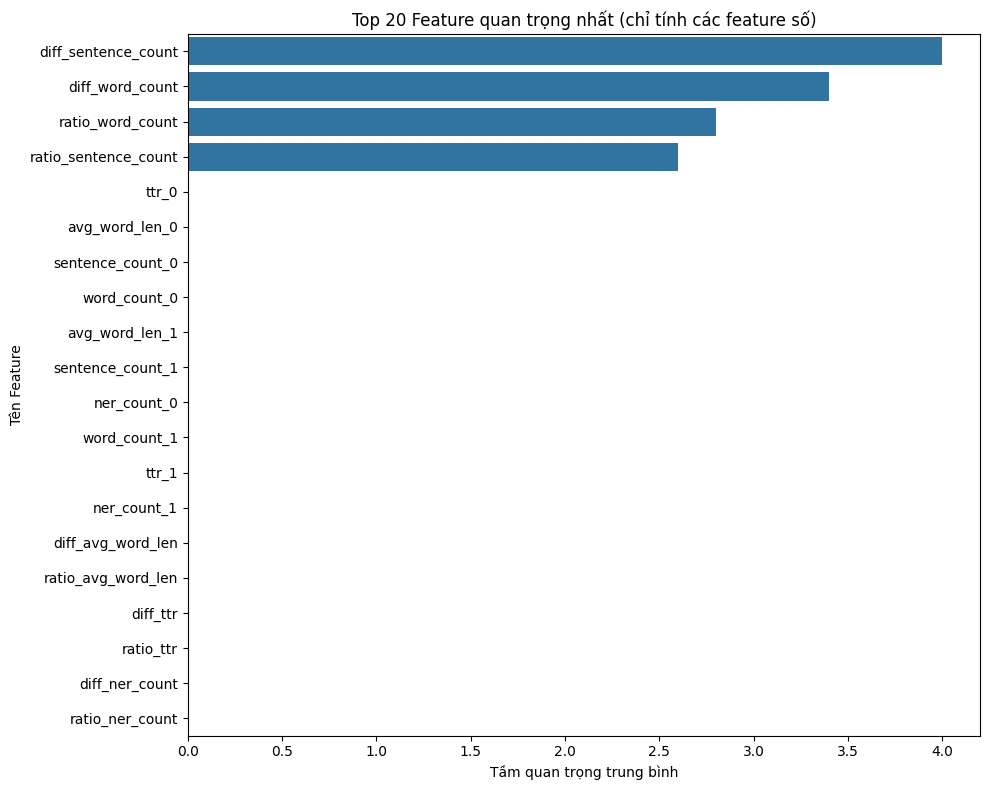

In [66]:
feature_importances["average"] = feature_importances.mean(axis=1)
feature_importances.index = numerical_features.columns
top_features = feature_importances.sort_values(by="average", ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features["average"], y=top_features.index)
plt.title("Top 20 Feature quan trọng nhất (chỉ tính các feature số)")
plt.xlabel("Tầm quan trọng trung bình")
plt.ylabel("Tên Feature")
plt.tight_layout()
plt.show()

### Fine tuning

In [ ]:
import optuna

def objective(trial):
    # 1. Định nghĩa không gian tìm kiếm cho các siêu tham số
    params = {
        'objective': 'binary',
        'random_state': 42,
        'n_estimators': 1000,
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    
    
    # 2. Chạy Cross-Validation với bộ tham số được gợi ý
    NFOLDS = 5
    folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
    oof_preds = np.zeros(X.shape[0])

    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='accuracy',
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        
        val_preds = model.predict(X_val)
        oof_preds[val_idx] = val_preds

    # 3. Trả về kết quả để Optuna đánh giá
    cv_accuracy = accuracy_score(y, oof_preds)
    return cv_accuracy

In [70]:
study = optuna.create_study(direction='maximize')

# Bắt đầu quá trình tối ưu, ví dụ chạy 50 lần thử nghiệm (trials)
# Bạn có thể tăng/giảm n_trials. Càng nhiều thì càng có khả năng tìm ra kết quả tốt hơn.
study.optimize(objective, n_trials=50)

# In ra kết quả
print("\n🏁 Quá trình tối ưu hóa hoàn tất!")
print("Số lần thử nghiệm:", len(study.trials))
print("Tham số tốt nhất tìm được:")
best_params = study.best_params
print(best_params)

print(f"\nĐiểm CV Accuracy cao nhất: {study.best_value:.4f}")

[I 2025-08-17 16:47:51,203] A new study created in memory with name: no-name-9edcf76e-269a-46c4-83b7-fb6176ca825f
[I 2025-08-17 16:47:51,652] Trial 0 finished with value: 0.8631578947368421 and parameters: {'learning_rate': 0.04763982095280229, 'num_leaves': 260, 'max_depth': 9, 'feature_fraction': 0.7382334946762771, 'bagging_fraction': 0.6954900683782532, 'bagging_freq': 4, 'lambda_l1': 1.6149353050271568e-05, 'lambda_l2': 0.0010135490521043346}. Best is trial 0 with value: 0.8631578947368421.
[I 2025-08-17 16:47:52,117] Trial 1 finished with value: 0.8105263157894737 and parameters: {'learning_rate': 0.05183050259793499, 'num_leaves': 282, 'max_depth': 5, 'feature_fraction': 0.8115489568285104, 'bagging_fraction': 0.8378063456214621, 'bagging_freq': 3, 'lambda_l1': 7.419889236555798e-07, 'lambda_l2': 0.268138274060217}. Best is trial 0 with value: 0.8631578947368421.
[I 2025-08-17 16:47:52,490] Trial 2 finished with value: 0.8105263157894737 and parameters: {'learning_rate': 0.08635


🏁 Quá trình tối ưu hóa hoàn tất!
Số lần thử nghiệm: 50
Tham số tốt nhất tìm được:
{'learning_rate': 0.09115332520822347, 'num_leaves': 185, 'max_depth': 8, 'feature_fraction': 0.720893351482937, 'bagging_fraction': 0.6189588309668991, 'bagging_freq': 6, 'lambda_l1': 2.646342164101471e-08, 'lambda_l2': 3.6779126954832445e-05}

Điểm CV Accuracy cao nhất: 0.8947


In [72]:
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X, y)

,boosting_type,'gbdt'
,num_leaves,185
,max_depth,8
,learning_rate,0.09115332520822347
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Test 

In [75]:
numerical_features_test = create_numerical_features(df_test)
sentences_0_test = df_test['text_0'].tolist()
sentences_1_test = df_test['text_1'].tolist()
embeddings_0_test = e5_model.encode(sentences_0_test, show_progress_bar=True)
embeddings_1_test = e5_model.encode(sentences_1_test, show_progress_bar=True)
e5_features_0_test = pd.DataFrame(embeddings_0_test, columns=[f'e5_0_{i}' for i in range(embedding_dims)])
e5_features_1_test = pd.DataFrame(embeddings_1_test, columns=[f'e5_1_{i}' for i in range(embedding_dims)])

tfidf_0_test = tfidf_vec_0.transform(df_test['text_0'])
tfidf_1_test = tfidf_vec_1.transform(df_test['text_1'])

dense_features_test = pd.concat([
    numerical_features_test.reset_index(drop=True),
    e5_features_0_test.reset_index(drop=True),
    e5_features_1_test.reset_index(drop=True)
], axis=1)

X_test = hstack([
    dense_features_test.values,
    tfidf_0_test,
    tfidf_1_test
]).tocsr()

print("🏁 Tạo feature cho tập test hoàn tất! Kích thước:", X_test.shape)

test_predictions = final_model.predict(X_test)
print("🏁 Dự đoán hoàn tất!")

Batches: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]


🏁 Tạo feature cho tập test hoàn tất! Kích thước: (1068, 4788)
🏁 Dự đoán hoàn tất!


In [79]:
from pathlib import Path

# --- Build submission -------------------------------------------------
submission = pd.DataFrame({
    "id": df_test.index,
    "real_text_id": test_predictions.astype(int)
}).sort_values("id")
submission['real_text_id'] = submission['real_text_id'].map({0: 1, 1: 2})


save_path = Path("test_5_tfidf_e5_lightgbm.csv")
submission.to_csv(save_path, index=False)
print(f"✅ Submission saved to {save_path.resolve()}")

✅ Submission saved to /home/thangquang09/CODE/CTAI_MachineLearning/notebooks/test_5_tfidf_e5_lightgbm.csv
